In [2]:
import numpy as np
import math 
import pandas as pd
from pandas.io.json import json_normalize
import json
import sys  
sys.path.insert(0, './scripts')
from PricingModels import *


trades = []
run_matrix=[]
cols = ["init.apy","init.percent_fee","init.days_until_maturity","init.max_order_size","init.time_stretch",\
        "init.market_price","init.target_liquidity","init.target_daily_volume","input.day","input.time",\
        "input.base_market_price", "input.unit_fyt_price","input.base_reserves","input.fyt_reserves",\
        "input.token_in","input.amount_specified","input.token_out","input.direction",\
        "output.trade_volume","output.fee","output.slippage"]

ybas = [
    {
        "vault" : "ySTETH",
        "apy" : 10,
        "market_price" : 2500,
        "days_until_maturity": 90,
    },
]


for target_daily_volume in [5000000,10000000]:
    for target_liquidity in [10000000]:
        for g in [.1]:
                for yba in ybas:
                    np.random.seed(2)
                    APY=yba["apy"]
                    days_until_maturity = yba["days_until_maturity"]
                    market_price = yba["market_price"]
                    time_stretch = Element_Pricing_Model.calc_time_stretch(APY)
                    run_matrix.append((yba,g,target_liquidity,target_daily_volume))

                    y_start = target_liquidity/market_price
                    max_order_price=12500
                    max_order_size=max_order_price/market_price 
                    sigma=max_order_size/10
                    liquidity = 0
                    
                    (x_start, y_start, liquidity) = Element_Pricing_Model.calc_liquidity(target_liquidity, market_price, APY, days_until_maturity, time_stretch)
                    
                    total_supply = x_start+y_start
                    t=days_until_maturity/(365*time_stretch)
                    step_size=t/days_until_maturity
                    epsilon=step_size/2
                    m = Market(x_start,y_start,g,t,total_supply,Element_Pricing_Model)
                    print("Days Until Maturity: " + str(days_until_maturity))
                    print("Time Stretch: " + str(time_stretch))
                    print("Fee %: " + str(g*100))
                    print("Max order size: " + str(max_order_size))
                    print("Starting APY: {:.2f}%".format(m.apy(days_until_maturity)))
                    print("Starting Spot Price: " + str(m.spot_price()))
                    print("Starting Liquidity: ${:,.2f}".format(liquidity))
                    print("Starting Base Reserves: " + str(m.x))
                    print("Starting PT Reserves: " + str(m.y))
                    x_orders=0
                    x_volume=0
                    y_orders=0
                    y_volume=0

                    total_fees = 0
                    todays_volume = 0
                    todays_fees = 0
                    todays_num_trades = 0
                    day=0
                    while m.t > epsilon:
                        day += 1
                        todays_volume = 0
                        todays_fees = 0
                        todays_num_trades = 0
                        maturity_ratio = day/days_until_maturity
                        ub=target_daily_volume*math.log10(1/maturity_ratio) # log(1/maturity ratio) is used to simulate waning demand over the lifetime of the fyt
                        todays_target_volume = np.random.uniform(ub/2,ub)
                        while todays_target_volume > todays_volume:
                            fee = -1
                            trade = []
                            while fee < 0:
                                # determine order size
                                amount = np.random.normal(max_order_size/2,sigma)
                                lb_amount = max(0.00001,amount)
                                amount = min(max_order_size,lb_amount)
                                # buy fyt or base
                                if np.random.uniform(0,1) < 0.5:
                                    token_in = "base"
                                    token_out = "fyt"
                                else:
                                    token_in = "fyt"
                                    token_out = "base"

                                if np.random.uniform(0,1) < 0.5:
                                    direction="in"
                                else:
                                    direction="out"
                                    

                                start_x_volume = m.x_volume
                                start_y_volume = m.y_volume
                                (without_fee_or_slippage,with_fee,without_fee,fee) = m.swap(amount,direction,token_in,token_out)
                                
                                trade = [APY,g,days_until_maturity,max_order_size,time_stretch,market_price,target_liquidity,target_daily_volume,day,m.t,market_price,m.spot_price(),m.x,m.y,token_in,amount,token_out,direction,with_fee*market_price,fee*market_price,(without_fee_or_slippage-without_fee)*market_price]
                                
                            trades.append(trade);
                            todays_volume += (m.x_volume - start_x_volume)*market_price + (m.y_volume - start_y_volume)*market_price
                            todays_fees += fee*market_price
                            todays_num_trades += 1
                        print("\tDay: " + str(day) + " PT Price: " + str(m.spot_price()) + " Implied APY: " + str(m.apy(days_until_maturity-day+1)) + " Target Volume Factor: {:,.4f}".format(math.log10(1/maturity_ratio)) + " Volume: ${:,.2f}".format(todays_volume) + " Num Trades: " + str(todays_num_trades) + " Fees: ${:,.2f}".format(todays_fees))
                        total_fees += todays_fees
                        m.tick(step_size)

                    print("Ending Liquidity: ${:,.2f}".format(m.x*market_price+m.y*market_price*m.spot_price()))
                    print("Total volume: ${:,.2f}".format(m.x_volume*market_price+m.y_volume*market_price))
                    print("Total fees: ${:,.2f}".format(total_fees))
                    print("Ending Base Reserves: " + str(m.x))
                    print("Delta Base Reserves: " + str(abs(x_start-m.x)))
                    print("Ending Bond Reserves: " + str(m.y))
                    print("Delta Bond Reserves: " + str(abs(y_start-m.y)))
                    print("Num base orders: " + str(m.x_orders))
                    print("Cum base volume: " + str(m.x_volume))
                    print("Num PT orders: " + str(m.y_orders))
                    print("Cum PT volume: " + str(m.y_volume))
                    print("Cum slippage Base: " + str(m.cum_x_slippage))
                    print("Cum slippage PT: " + str(m.cum_y_slippage))
                    print("Cum fees Base: " + str(m.cum_x_fees))
                    print("Cum fees PT: " + str(m.cum_y_fees))
                    print("Ending PT Price: " + str(m.spot_price()))
                    print("Ending Time: " + str(m.t))
                    print("##################################################################")



#df = pd.DataFrame.from_dict(json_normalize(trades), orient='columns')
df = pd.DataFrame(trades,columns=cols)




Days Until Maturity: 90
Time Stretch: 11.093438508425958
Fee %: 10.0
Max order size: 5.0
Starting APY: 10.00%
Starting Spot Price: 0.9753424657534245
Starting Liquidity: $9,696,383.27
Starting Base Reserves: 1927.8683780719596
Starting PT Reserves: 2000.0
	Day: 1 PT Price: 0.9736229230376374 Implied APY: 10.697370101402601 Target Volume Factor: 1.9542 Volume: $7,016,113.87 Num Trades: 1132 Fees: $17,911.83
	Day: 2 PT Price: 0.975748548259 Implied APY: 9.945820096028076 Target Volume Factor: 1.6532 Volume: $6,739,048.61 Num Trades: 1081 Fees: $17,089.73
	Day: 3 PT Price: 0.9760598134987454 Implied APY: 9.92973644654311 Target Volume Factor: 1.4771 Volume: $6,493,522.35 Num Trades: 1041 Fees: $15,568.93
	Day: 4 PT Price: 0.9749103017143772 Implied APY: 10.526137786496921 Target Volume Factor: 1.3522 Volume: $4,390,246.72 Num Trades: 704 Fees: $11,074.99
	Day: 5 PT Price: 0.974980586320176 Implied APY: 10.6187046431811 Target Volume Factor: 1.2553 Volume: $5,783,179.75 Num Trades: 927 Fee

	Day: 7 PT Price: 0.972903122027437 Implied APY: 11.774238642839872 Target Volume Factor: 1.1091 Volume: $7,924,226.98 Num Trades: 1272 Fees: $21,573.05
	Day: 8 PT Price: 0.9728755233024456 Implied APY: 11.928233728442578 Target Volume Factor: 1.0512 Volume: $7,972,228.10 Num Trades: 1268 Fees: $22,712.28
	Day: 9 PT Price: 0.9746475966194326 Implied APY: 11.284911260862334 Target Volume Factor: 1.0000 Volume: $5,807,752.84 Num Trades: 918 Fees: $15,054.40
	Day: 10 PT Price: 0.9769150714460121 Implied APY: 10.402467805192085 Target Volume Factor: 0.9542 Volume: $9,163,353.23 Num Trades: 1463 Fees: $22,640.17
	Day: 11 PT Price: 0.9781329817492996 Implied APY: 9.976827076882042 Target Volume Factor: 0.9128 Volume: $5,734,973.78 Num Trades: 907 Fees: $12,757.29
	Day: 12 PT Price: 0.9765790615974729 Implied APY: 10.821066477116963 Target Volume Factor: 0.8751 Volume: $5,350,823.90 Num Trades: 856 Fees: $12,289.88
	Day: 13 PT Price: 0.9790619504346367 Implied APY: 9.797933450458453 Target Vo

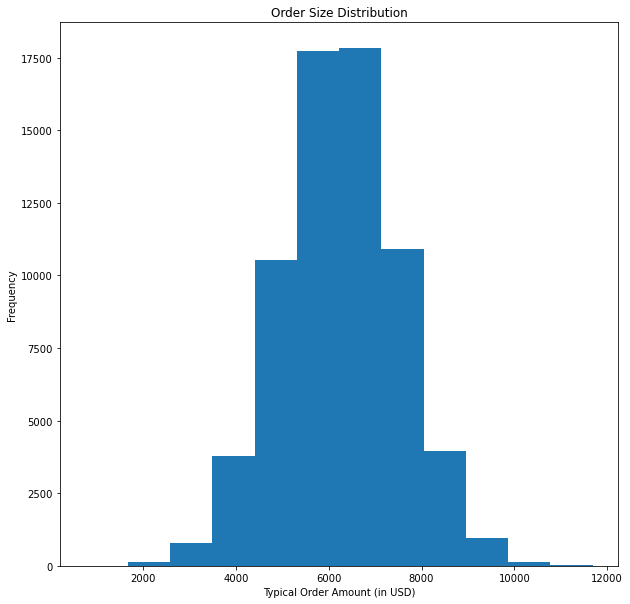

In [3]:
import matplotlib.pyplot as plt

hist=df['output.trade_volume'].plot.hist(bins=12,title="Order Size Distribution",figsize=(10,10));
hist=hist.set_xlabel("Typical Order Amount (in USD)")

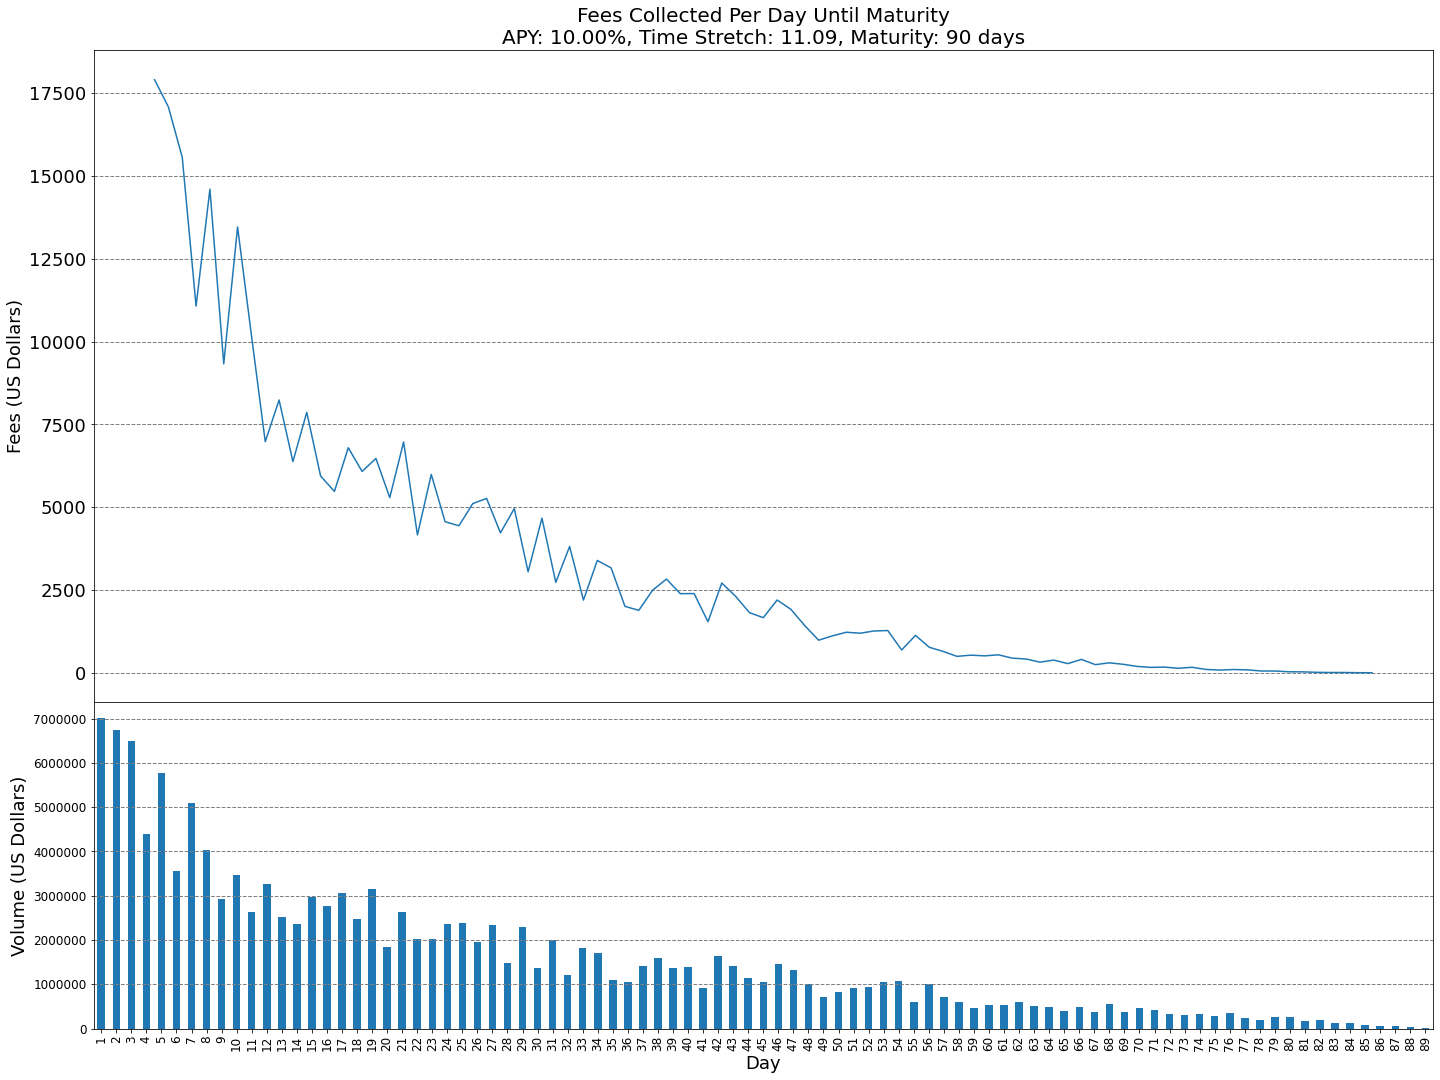

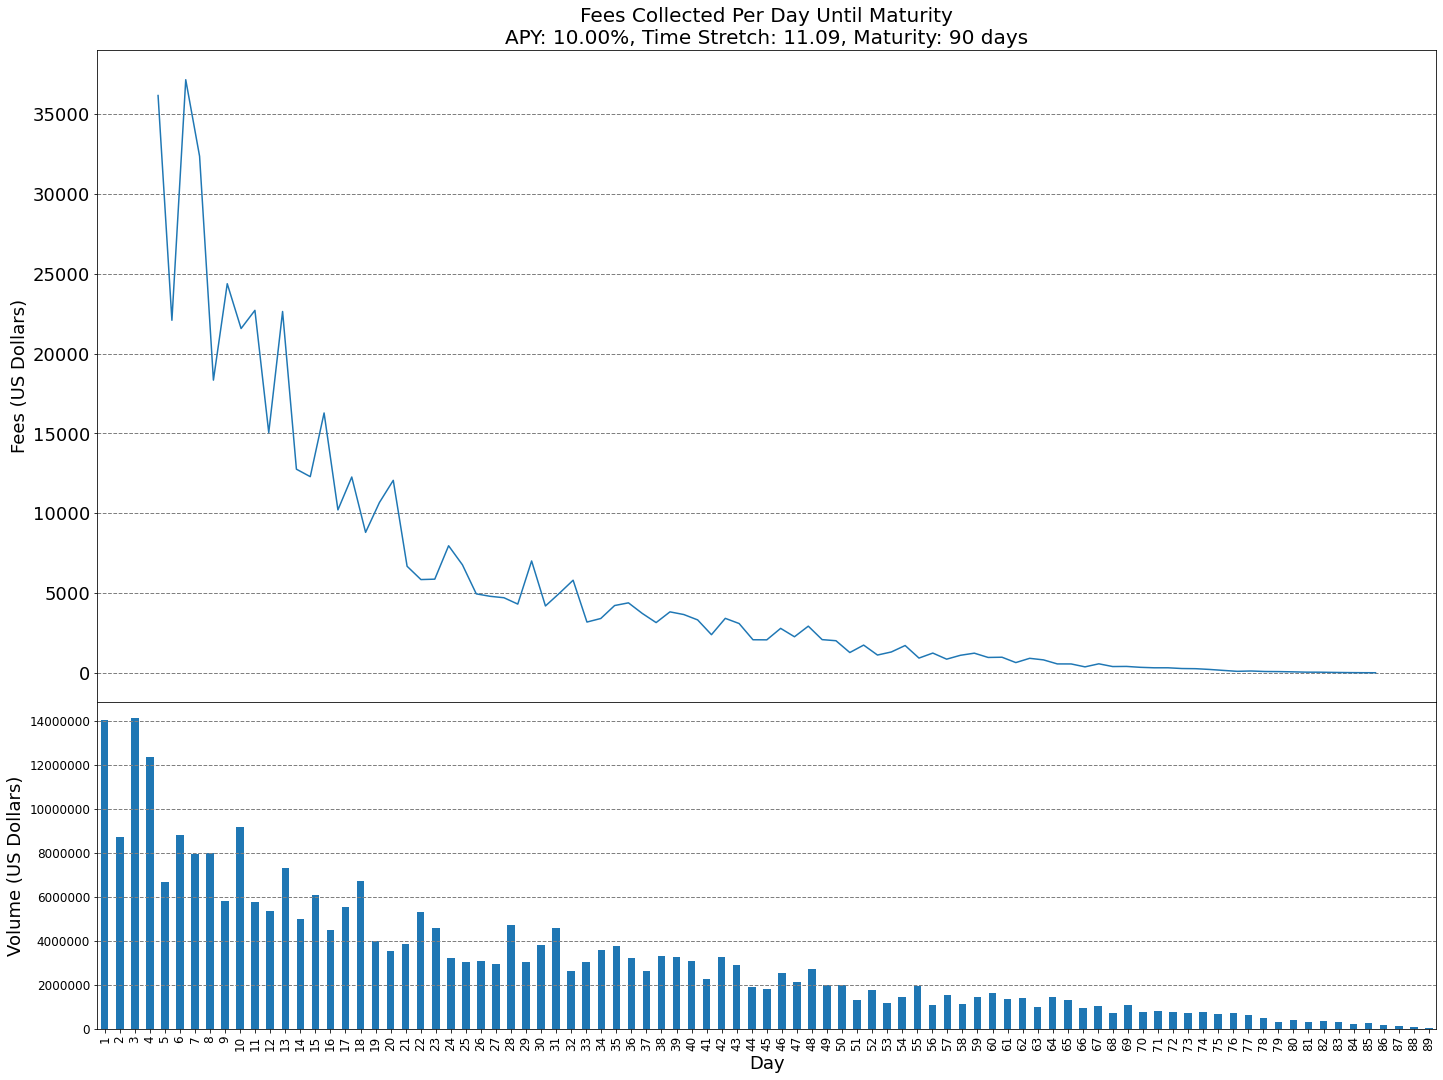

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

dfs=[]
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  dfs.append(df[ (df['init.market_price']==yba["market_price"]) & (df['init.apy']==yba["apy"]) & (df['init.percent_fee']==g) & (df['init.days_until_maturity']==yba["days_until_maturity"]) & (df['init.target_liquidity']==target_liquidity) & (df['init.target_daily_volume']==target_daily_volume)].reset_index())

for _df in dfs:
    fig, ax = plt.subplots(ncols=1, nrows=2,gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[2,1]})
    df_fees_volume = _df.groupby(['input.day']).agg({'output.trade_volume':['sum']\
                                   ,'output.fee':['mean','std','min','max','sum']\
                                  })
    df_fees_volume.columns = ['_'.join(col).strip() for col in df_fees_volume.columns.values]
    df_fees_volume = df_fees_volume.reset_index()
    ax[0] = df_fees_volume.plot(x="input.day", y="output.fee_sum",figsize=(24,18),ax=ax[0]);
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Fees (US Dollars)",fontsize=18)
    ax[0].tick_params(axis = "both", labelsize=18)
    ax[0].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[0].xaxis.set_ticklabels([])
    title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Time Stretch: {:.2f}, Maturity: {:} days".format(_df['init.apy'][0],_df['init.time_stretch'][0],_df['init.days_until_maturity'][0])
    ax[0].set_title(title,fontsize=20)
    ax[0].legend().set_visible(False)

    ax[1] = df_fees_volume.plot(kind='bar',x="input.day", y="output.trade_volume_sum",ax=ax[1]);
    ax[1].set_xlabel("Day",fontsize=18)
    ax[1].set_ylabel("Volume (US Dollars)",fontsize=18)
    ax[1].tick_params(axis = "both", labelsize=12)
    ax[1].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[1].legend().set_visible(False)
    ax[1].ticklabel_format(style='plain',axis='y')
    fig.subplots_adjust(wspace=None, hspace=None)

In [6]:
df_fees_volume

,input.day,output.trade_volume_sum,output.fee_mean,output.fee_std,output.fee_min,output.fee_max,output.fee_sum
0,1,1.403347e+07,16.106111,3.223353,5.887640,27.108950,36174.324862
1,2,8.693862e+06,15.733113,3.160288,5.888385,27.012606,22089.291014
2,3,1.412354e+07,16.473663,3.337757,4.713191,28.769634,37164.582846
3,4,1.233124e+07,16.405912,3.329208,4.848177,27.579530,32368.864583
4,5,6.670564e+06,17.251438,3.473024,7.169794,27.536706,18338.279083
...,...,...,...,...,...,...,...
84,85,2.390878e+05,0.958610,0.180614,0.579647,1.382220,35.468581
85,86,1.755070e+05,0.742224,0.144077,0.471611,1.043193,21.524493
86,87,1.117508e+05,0.608261,0.135972,0.378857,0.851281,10.948699
87,88,5.859233e+04,0.390365,0.118107,0.117279,0.540306,4.294017


In [7]:
pd.options.display.float_format = '{:,.8f}'.format
df_fees_agg = df.groupby(['init.apy','init.percent_fee','init.time_stretch','init.market_price','init.target_liquidity','init.days_until_maturity','init.target_daily_volume']).agg({'output.fee':['count','sum'],'output.trade_volume':['sum'],'output.slippage':['mean'],'input.amount_specified':['mean']})
df_fees_agg.columns = ['_'.join(col).strip() for col in df_fees_agg.columns.values]
df_fees_agg = df_fees_agg.reset_index()
df_fees_agg['init.percent_fee'] = df_fees_agg['init.percent_fee'].round(2)
df_fees_agg['output.mean_daily_volume'] = df_fees_agg['output.trade_volume_sum']/df_fees_agg['init.days_until_maturity']
df_fees_agg['output.apr'] = (df_fees_agg['output.fee_sum']/df_fees_agg['init.target_liquidity']) * (365/df_fees_agg['init.days_until_maturity'])*100
df_fees_agg = df_fees_agg.drop(columns=['input.amount_specified_mean']).reset_index()
df_fees_agg

,index,init.apy,init.percent_fee,init.time_stretch,init.market_price,init.target_liquidity,init.days_until_maturity,init.target_daily_volume,output.fee_count,output.fee_sum,output.trade_volume_sum,output.slippage_mean,output.mean_daily_volume,output.apr
0,0,10,0.10000000,11.09343851,2500,10000000,90,5000000,22411,"289,869.82688000","140,113,082.58249271",0.00013860,"1,556,812.02869436",11.75583187
1,1,10,0.10000000,11.09343851,2500,10000000,90,10000000,44300,"501,422.24523471","276,382,190.04050672",-0.00042074,"3,070,913.22267230",20.33545772


In [8]:
#df_fees_agg.to_csv("fees.csv")
#print(df_fees_agg[['init.target_liquidity','init.target_daily_volume','output.fee_sum','output.trade_volume_sum','output.mean_daily_volume','output.apr']].to_markdown(index=False))

print(df_fees_agg[['init.target_liquidity','output.trade_volume_sum','output.mean_daily_volume','output.apr']].to_markdown(index=False,floatfmt=(",.0f", ",.0f",",.0f",",.2f")))

|   init.target_liquidity |   output.trade_volume_sum |   output.mean_daily_volume |   output.apr |
|------------------------:|--------------------------:|---------------------------:|-------------:|
|              10,000,000 |               140,113,083 |                  1,556,812 |        11.76 |
|              10,000,000 |               276,382,190 |                  3,070,913 |        20.34 |


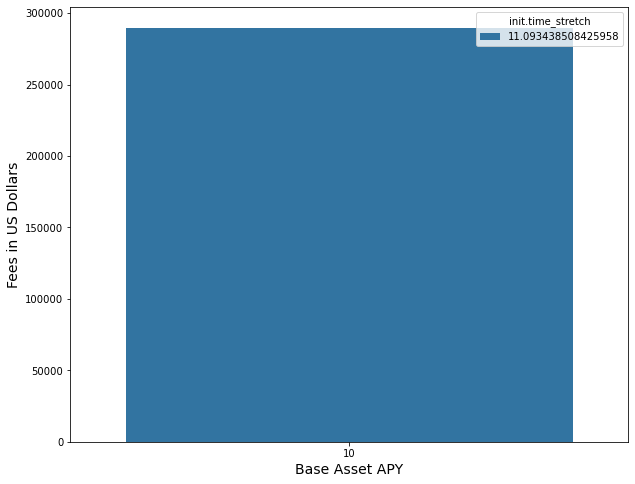

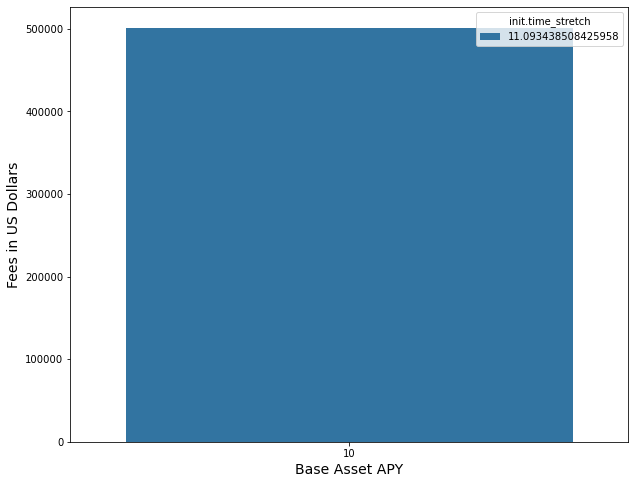

In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

#plt.figure(figsize=(20, 20))
#for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
#condition = (df_fees_agg['init.market_price']==yba["market_price"]) & (df_fees_agg['init.days_until_maturity']==yba["days_until_maturity"]) & (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  plt.figure(figsize=(10, 8))
  condition =   (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
  sns.barplot(x="init.apy", 
              y="output.fee_sum", 
              hue="init.time_stretch", 
              data=df_fees_agg[condition],
              ci=None)
  plt.ticklabel_format(style='plain',axis='y')
  plt.ylabel("Fees in US Dollars", size=14)
  plt.xlabel("Base Asset APY", size=14)
  #title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Fee: {:.2f}%, Maturity: {:} days\nTarget Daily Volume: \${:,.2f}, Target Liquidity: \${:,.2f}".format(_df['init.apy'][0],_df['init.percent_fee'][0]*100,_df['init.days_until_maturity'][0],_df['init.target_daily_volume'][0],_df['init.target_liquidity'][0])
  #plt.title("Cumulative Fees for 30 day FYT\n"+"Target Volume = " + str(df_fees_agg[condition]['init.target_daily_volume'].iloc[0]) + "\nTarget Liquidity = " + str(df_fees_agg[condition]['init.target_liquidity'].iloc[0]), size=14)
